In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio

In [2]:
with fitsio.FITS("data/qsos_noisy.fits", "r") as h:
    flux_noisy = h["FLUX"][:, :10000]#.read()
    ivar = h["IVAR"][:, :10000]#.read()
    w_grid = h["WAVELENGTH"].read()
    z = h["Z"][:10000]#.read()

In [3]:
with fitsio.FITS("data/qsos_noisy_no_renorm.fits", "r") as h:
    flux_renorm = h["FLUX"][:, :10000]#.read()
    ivar_renorm = h["IVAR"][:, :10000]#.read()
    # w_grid = h["WAVELENGTH"].read()
    z_renorm = h["Z"][:10000]#.read()

In [4]:
rng = np.random.default_rng(1009921)

In [5]:
# Low Redshift
idx_1 = np.where(z < 0.1)
choice_1 = rng.choice(idx_1, size=1, replace=False, axis=1)[0]

f_choice_1 = flux_renorm[:, choice_1] * (ivar_renorm[:, choice_1] != 0)
f_choice_1[f_choice_1 == 0] = np.nan

f_noisy_1 = flux_noisy[:, choice_1] * (ivar[:, choice_1] != 0)
f_noisy_1[f_noisy_1 == 0] = np.nan

# Intermediary Redshift
idx_2 = np.where((z >= 1.4) & (z < 2.1))
choice_2 = rng.choice(idx_2, size=1, replace=False, axis=1)[0]
f_choice_2 = flux_renorm[:, choice_2] * (ivar[:, choice_2] != 0)
f_choice_2[f_choice_2 == 0] = np.nan

f_noisy_2 = flux_noisy[:, choice_2] * (ivar[:, choice_2] != 0)
f_noisy_2[f_noisy_2 == 0] = np.nan

# High Redshift
idx_3 = np.where((z >= 3.2))
choice_3 = rng.choice(idx_3, size=1, replace=False, axis=1)[0]
f_choice_3 = flux_renorm[:, choice_3] * (ivar[:, choice_3] != 0)
f_choice_3[f_choice_3 == 0] = np.nan

f_noisy_3 = flux_noisy[:, choice_3] * (ivar[:, choice_3] != 0)
f_noisy_3[f_noisy_3 == 0] = np.nan

In [6]:
z[choice_1], z_renorm[choice_1]

(array([0.05651018], dtype=float32), array([0.05651018], dtype=float32))

In [7]:
X = flux_noisy
V = ivar

In [8]:
H_nearly = np.load("templates/H_nearly_no_lya.npy")
W_nearly = np.load("templates/W_nearly_no_lya.npy")
recon_nearly = W_nearly @ H_nearly
chi_2_nearly = np.sum((np.sqrt(V) * (X - recon_nearly[:, :10000])) ** 2, axis=0)

In [9]:
H_shift = np.load("templates/H_shift_no_lya.npy")
W_shift = np.load("templates/W_shift_no_lya.npy")
recon_shift = W_shift @ H_shift
chi_2_shift = np.sum((np.sqrt(V) * (X - recon_shift[:, :10000])) ** 2, axis=0)

In [10]:
noisy = [f_noisy_1, f_noisy_2, f_noisy_3]
renorm = [f_choice_1, f_choice_2, f_choice_3]
redshifts = [z[choice_1][0], z[choice_2][0], z[choice_3][0]]
choices = [choice_1, choice_2, choice_3]


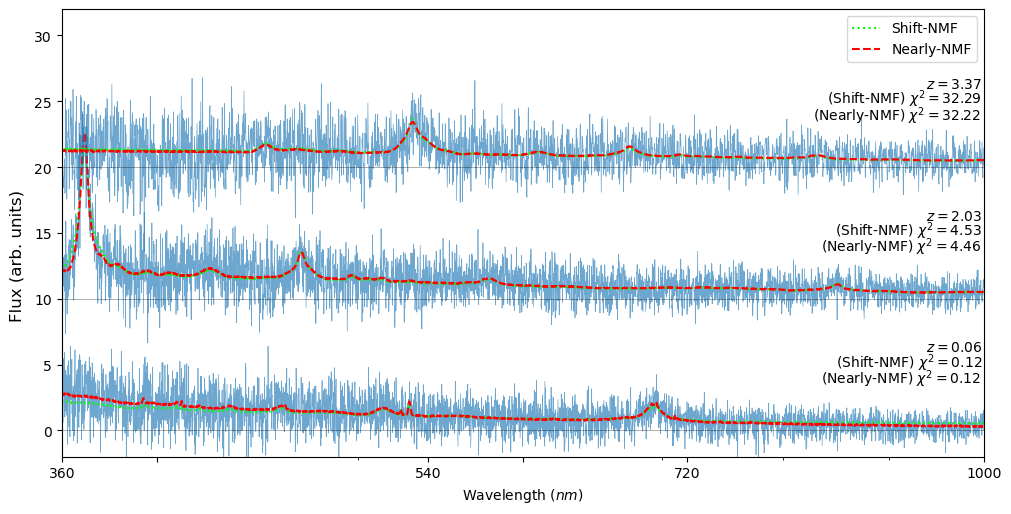

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="constrained")

offset = 10
text_offset = 2
scale_range = (w_grid > 3600) & (w_grid < 10000)
for i in range(len(noisy)):
    
    ax.plot(w_grid * (1 + redshifts[i]), renorm[i] + offset * i, c="C0", lw=0.5, alpha=0.65)
    ylim = ax.get_ylim() # Want to set the ylims by the original spectra not the reconstruction
    
    scale = np.nanmedian(renorm[i]) / np.nanmedian(noisy[i])
    label = "Shift-NMF" if i == 0 else None
    ax.plot(w_grid * (1 + redshifts[i]), recon_shift[:, choices[i]] * scale + offset * i, c="lime", ls="dotted", lw=1.5, label=label)
    label = "Nearly-NMF" if i == 0 else None
    ax.plot(w_grid * (1 + redshifts[i]), recon_nearly[:, choices[i]] * scale + offset * i, c="red", ls="dashed", lw=1.5, label=label)

    # Annotating their redshifts
    this_z = str(np.round(redshifts[i], decimals=2))
    ax.text(10000 - 20, text_offset * 3 + i * offset, f"$z=${this_z}", ha="right")
    shift_chi = np.round(chi_2_shift[choices[i]][0], decimals=2)
    nearly_chi = np.round(chi_2_nearly[choices[i]][0], decimals=2)
    ax.text(10000 - 20, text_offset * 2.42 + i * offset, f"(Shift-NMF) $\chi^2={shift_chi}$", ha="right")
    ax.text(10000 - 20, text_offset * 1.80 + i * offset,   f"(Nearly-NMF) $\chi^2={nearly_chi}$ ", ha="right")

    ax.axhline(y=offset * i, alpha=0.45, c="k", lw=0.5)

ax.set(xscale="log",  xlim=(3600, 10000), ylim=(-2, 32))

# Last two clear the ones already there.
x_labels = np.asarray([360, 540, 720, 1000, 400, 600])
ax.set_xticks(x_labels*10, np.hstack([x_labels[:-2], ["", ""]]))
ax.legend(loc="upper right")
    
    
fig.supylabel("Flux (arb. units)")
plt.xlabel("Wavelength ($nm$)")
plt.savefig("plots/qso_recons.pdf", bbox_inches="tight", dpi=256)